# Powerflow

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../../..')
import ml4ps as mp

In [2]:
backend = mp.PandaPowerBackend()

In [3]:
train_dir = '../../../data/case60_A/train'
normalizer = mp.Normalizer(data_dir=train_dir, backend=backend, n_samples=1000)

Building a Normalizer.


Building normalizing functions.: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 19.95it/s]


Normalizer ready to normalize !


In [4]:
train_set = mp.PowerGridDataset(data_dir=train_dir, backend=backend, normalizer=normalizer)

In [5]:
train_loader = DataLoader(train_set,
                          batch_size=8,
                          shuffle=True,
                          num_workers=8,
                          collate_fn=mp.power_grid_collate)

In [6]:
input_features = {}
input_features['bus']       = ['in_service', 'max_vm_pu', 'min_vm_pu', 'vn_kv']
input_features['load']      = ['const_i_percent', 'const_z_percent', 'controllable', 'in_service', 
                               'p_mw', 'q_mvar', 'scaling', 'sn_mva']
input_features['gen']       = ['in_service', 'p_mw', 'scaling', 'sn_mva', 'vm_pu', 'slack', 'max_p_mw', 
                               'min_p_mw', 'max_q_mvar', 'min_q_mvar', 'slack_weight']
input_features['shunt']     = ['q_mvar', 'p_mw', 'vn_kv', 'step', 'max_step', 'in_service']
input_features['ext_grid']  = ['in_service', 'va_degree', 'vm_pu', 'max_p_mw', 'min_p_mw', 'max_q_mvar',
                               'min_q_mvar', 'slack_weight']
input_features['line']      = ['c_nf_per_km', 'df', 'g_us_per_km', 'in_service', 'length_km', 'max_i_ka',
                               'max_loading_percent', 'parallel', 'r_ohm_per_km', 'x_ohm_per_km']
input_features['trafo']     = ['df', 'i0_percent', 'in_service', 'max_loading_percent', 'parallel', 
                               'pfe_kw', 'shift_degree', 'sn_mva', 'tap_max', 'tap_neutral', 'tap_min', 
                               'tap_phase_shifter', 'tap_pos', 'tap_side', 'tap_step_degree', 
                               'tap_step_percent', 'vn_hv_kv', 'vn_lv_kv', 'vk_percent', 'vkr_percent']
input_features['poly_cost'] = ['cp0_eur', 'cp1_eur_per_mw', 'cp2_eur_per_mw2', 'cq0_eur', 
                               'cq1_eur_per_mvar', 'cq2_eur_per_mvar2']

output_features = {}
output_features['bus'] = ['res_vm_pu']

In [7]:
a, x, nets = next(iter(train_loader))
n_obj = {k: np.max([np.shape(x_k_f)[1] for f, x_k_f in x[k].items()]) 
         for k in list(input_features.keys())+list(output_features.keys())}

In [8]:
n_obj

{'bus': 60,
 'load': 22,
 'gen': 22,
 'shunt': 12,
 'ext_grid': 1,
 'line': 57,
 'trafo': 31,
 'poly_cost': 23}

In [9]:
fully_connected = mp.FullyConnected(input_features=input_features,
                        output_features=output_features,
                        n_obj=n_obj,
                        hidden_dimensions=[128,128])

In [10]:
functions = {'bus': {'res_vm_pu': [mp.AffineTransform(offset=1.)]}}
postprocessor = mp.PostProcessor(functions=functions)

In [11]:
from jax.example_libraries import optimizers

step_size = 3e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(fully_connected.weights)

In [12]:
def loss(params, x, y):
    y_hat = fully_connected.batch_forward(params, x)
    y_post = postprocessor(y_hat)
    loss_mag = jnp.mean((y_post['bus']['res_vm_pu'] - y['bus']['res_vm_pu'])**2)
    return loss_mag

@jax.jit
def update(params, x, y, opt_state, step):
    value, grads = jax.value_and_grad(loss)(params, x, y)
    opt_state = opt_update(step, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [13]:
train_losses = []
step = 0

In [21]:
for a, x, nets in tqdm.tqdm(train_loader):
    step += 1
    y = backend.update_run_extract(nets, features={'bus':['res_vm_pu']})
    fully_connected.weights, opt_state, train_loss = update(fully_connected.weights, x, y, opt_state, step)
    train_losses.append(train_loss)

  2%|██████▋                                                                                                                                                                                                                                                                      | 312/12500 [01:38<1:04:22,  3.16it/s]


KeyboardInterrupt: 

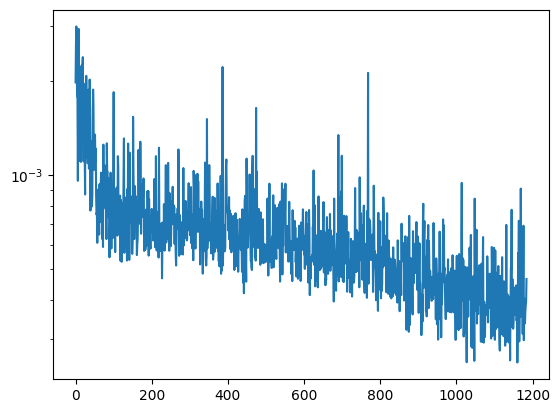

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.yscale('log')
plt.show()

In [19]:
a, x, nets = next(iter(train_loader))

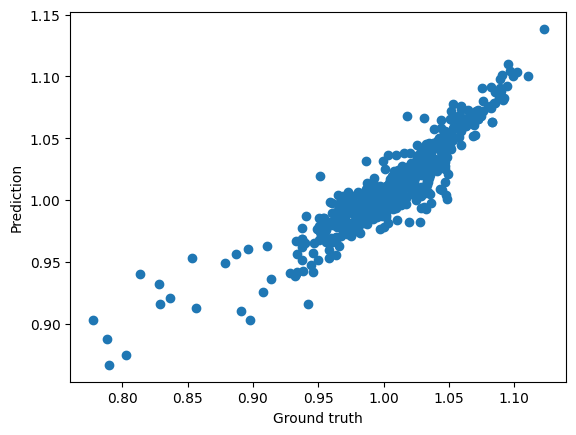

In [23]:
# Perform prediction
#x_norm = normalizer(x)
y_hat = fully_connected.batch_forward(fully_connected.weights, x)
y_post = postprocessor(y_hat)
y_post = np.reshape(y_post['bus']['res_vm_pu'], [-1])

# Get ground truth
y_truth = backend.update_run_extract(nets, features={'bus':['res_vm_pu']})
y_truth = np.reshape(y_truth['bus']['res_vm_pu'], [-1])

# Compare results
plt.scatter(y_truth, y_post)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()

In [ ]:
nets[0]